In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import MobileNetV2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing

In [ ]:
!unzip /content/drive/MyDrive/ifood-2019-fgvc6.zip

Streaming output truncated to the last 5000 lines.
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_007118.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_007118.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_000306.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_000306.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_000060.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_000060.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_003031.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_003031.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_009643.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_009643.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_003805.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_003805.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_003581.jpg  

In [ ]:
num_classes = 251
width, height = 224, 224
train_dir = '/content/ifood-2019-fgvc6/organized_train_set'
val_dir = '/content/ifood-2019-fgvc6/organized_val_set'
test_dir = '/content/ifood-2019-fgvc6/test_set'
batch_size = 32

In [ ]:
csv_path = '/content/drive/MyDrive/train_incorrect.csv'

incorrect_images_df = pd.read_csv(csv_path, header=None)
incorrect_images = incorrect_images_df[0].tolist()  # Access the first (and only) column

for root, dirs, files in os.walk(train_dir):  # Traverse through all class subdirectories
    for img_file in incorrect_images:
        img_path = os.path.join(root, img_file)
        if os.path.exists(img_path):
            os.remove(img_path)
            print(f"Removed {img_file} from {root}")
        #else:
           # print(f"{img_file} not found in {root}")

Removed train_061029.jpg from /content/ifood-2019-fgvc6/organized_train_set/170
Removed train_061038.jpg from /content/ifood-2019-fgvc6/organized_train_set/170
Removed train_061069.jpg from /content/ifood-2019-fgvc6/organized_train_set/170
Removed train_061101.jpg from /content/ifood-2019-fgvc6/organized_train_set/170
Removed train_061105.jpg from /content/ifood-2019-fgvc6/organized_train_set/170
Removed train_061111.jpg from /content/ifood-2019-fgvc6/organized_train_set/170
Removed train_061119.jpg from /content/ifood-2019-fgvc6/organized_train_set/170
Removed train_061120.jpg from /content/ifood-2019-fgvc6/organized_train_set/170
Removed train_061271.jpg from /content/ifood-2019-fgvc6/organized_train_set/170
Removed train_061275.jpg from /content/ifood-2019-fgvc6/organized_train_set/170
Removed train_061297.jpg from /content/ifood-2019-fgvc6/organized_train_set/170
Removed train_061300.jpg from /content/ifood-2019-fgvc6/organized_train_set/170
Removed train_061327.jpg from /content/i

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='categorical',
)

val_set = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 114154 images belonging to 251 classes.
Found 11994 images belonging to 251 classes.


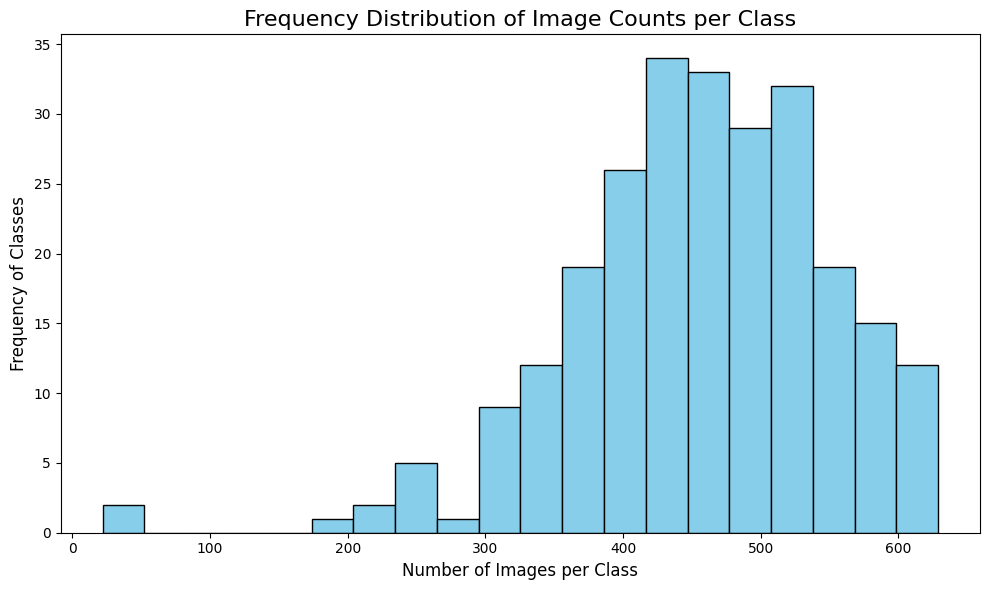

In [ ]:
# Get a list of all class directories
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Count the number of images in each class directory
class_counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in class_dirs]

# Plot the frequency of image counts using a histogram
plt.figure(figsize=(10, 6))
plt.hist(class_counts, bins=20, color='skyblue', edgecolor='black')

plt.title('Frequency Distribution of Image Counts per Class', fontsize=16)
plt.xlabel('Number of Images per Class', fontsize=12)
plt.ylabel('Frequency of Classes', fontsize=12)

plt.tight_layout()

# Display the frequency chart
plt.show()



In [ ]:
from sklearn.utils import class_weight

class_labels = train_set.classes  # Labels for each image in the training set

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(class_labels),
                                                  y=class_labels)

# Keras requires dict format
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.7323620173091852, 1: 0.8564911727853183, 2: 1.4212400398406375, 3: 1.060132430650359, 4: 0.915084130279686, 5: 0.8406595429741294, 6: 1.7492185105730922, 7: 0.9951790213326126, 8: 0.963552569383483, 9: 0.9514577672573306, 10: 0.9281567607122531, 11: 1.1174368863611892, 12: 1.3455527004408403, 13: 0.7950993229877692, 14: 1.062609375581785, 15: 0.8900133321898317, 16: 0.8746092552865461, 17: 1.0479189233848019, 18: 0.9615154603573023, 19: 0.79095097869392, 20: 20.672582397682, 21: 0.7395070126000065, 22: 0.8092469977740284, 23: 0.7443483023715286, 24: 0.7517302690066181, 25: 0.8150480515215125, 26: 1.252883781677697, 27: 0.9865440623622647, 28: 0.8662796433314361, 29: 0.8485015163227686, 30: 1.0701101476447152, 31: 0.9059697465119602, 32: 1.075169770092208, 33: 1.2325116876666775, 34: 0.804950111060184, 35: 1.0958959343349493, 36: 0.8746092552865461, 37: 1.1572437983435215, 38: 0.9844086856039047, 39: 1.075169770092208, 40: 1.1661456737153948, 41: 1.0407249719656841,

# Model Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_dir = '/content/drive/MyDrive/CNN_Model_Tests'
os.makedirs(checkpoint_dir, exist_ok=True)

# Callbacks
Callbacks = [
    ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'Created_Dense_Best.keras'),
                    save_best_only=True,
                    monitor='val_loss',
                    mode='min',
                    verbose=1),  # Save the best model based on validation loss
    EarlyStopping(monitor='val_loss',
                  patience=5,  # Stop training after 5 epochs without improvement
                  mode='min',
                  verbose=1,
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.2,  # Reduce learning rate by 20%
                      patience=3,  # Reduce if no improvement after 3 epochs
                      mode='min',
                      verbose=1),
]

In [ ]:
from keras.callbacks import Callback

class SaveHistory(Callback):
    def __init__(self, save_path):
        super(SaveHistory, self).__init__()
        self.save_path = save_path
        # Load history if exists
        if os.path.exists(self.save_path):
            with open(self.save_path, 'rb') as f:
                self.history = pickle.load(f)
        else:
            self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    def on_epoch_end(self, epoch, logs=None):
        # Append new logs to the existing history
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))

        # Save history to a file
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)
        print(f"Epoch {epoch+1} history saved to {self.save_path}")

history_save_path = '/content/drive/MyDrive/CNN_Model_Tests/created_Dense_train_history_4.pkl'

history_callback = SaveHistory(save_path=history_save_path)


# DenseNet201 Testing

In [ ]:
resnet = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False,input_shape=(width,width,3))
for layer in resnet.layers[:100]:
    layer.trainable=False

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(300,activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_set,
        validation_data = val_set,
        epochs=8,
        verbose=1,
        class_weight= class_weights_dict,
        callbacks=[Callbacks, history_callback]
         )

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1784/1784 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1032 - loss: 4.7617
Epoch 1: val_loss improved from inf to 2.25052, saving model to /_best_model.keras
Epoch 1 history saved to /content/drive/MyDrive/resnet_test2/resnet_training_history.pkl
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 2313s 1s/step - accuracy: 0.1033 - loss: 4.7613 - val_accuracy: 0.4772 - val_loss: 2.2505 - learning_rate: 1.0000e-04
Epoch 2/8
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3486 - loss: 2.9931
Epoch 2: val_loss improved from 2.25052 to 1.88018, saving model to /_best_model.keras
Epoch 2 history saved to /content/drive/MyDrive/resnet_test2/resnet_training_history.pkl
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 1867s 1s/step - accuracy: 0.3486 - loss: 2.9930 - val_accuracy: 0.5515 - val_loss: 1.8802 - learning_rate: 1.0000e-04
Epoch 3/8
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4406 - loss: 2.4816
Epoch 3: val_loss improved from 1.88018 to 1.74909, saving model to /_best_model.keras
Epoch 3 history sav

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-c989ad1476fe>", line 8, in <cell line: 8>
    history = model.fit(train_set,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit
    logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 833, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorph

TypeError: object of type 'NoneType' has no len()

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 35,990,285 (137.29 MB)

 Trainable params: 11,939,787 (45.55 MB)

 Non-trainable params: 7,034,048 (26.83 MB)

 Optimizer params: 17,016,450 (64.91 MB)

In [ ]:
# Evaluate the model
score = model.evaluate(val_set, verbose=1)
print("\nTest accuracy:", score[1])

Collab Auto Ends Runtime After 3.5 HRS, Data Logged After Each Epoch So We Load
All Files, Combine, And Plot Data

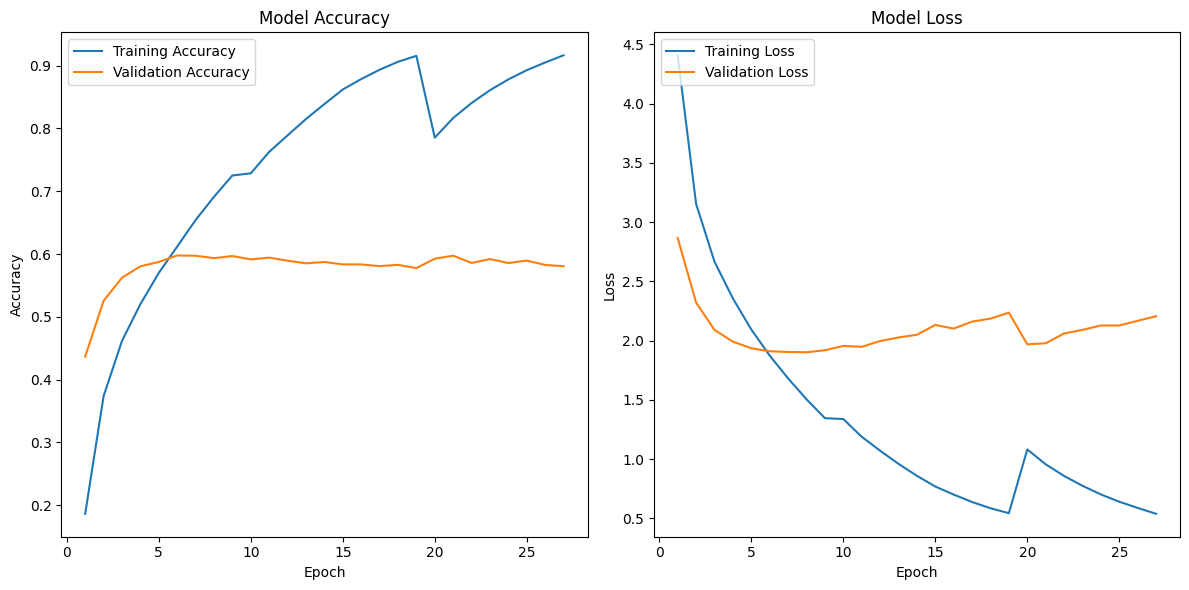

In [ ]:
# Load the history from all sessions
with open('/content/drive/MyDrive/resnet_training_history.pkl', 'rb') as file:
    history1 = pickle.load(file)

with open('/content/drive/MyDrive/resnet_training_history_2.pkl', 'rb') as file:
    history2 = pickle.load(file)

with open('/content/drive/MyDrive/resnet_training_history_3.pkl', 'rb') as file:
    history3 = pickle.load(file)

# Combine the histories
combined_history = {}
for key in history1.keys():
    combined_history[key] = history1[key] + history2[key] + history3[key]


epochs = np.arange(1, len(combined_history['loss']) + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, combined_history['accuracy'], label='Training Accuracy')
plt.plot(epochs, combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, combined_history['loss'], label='Training Loss')
plt.plot(epochs, combined_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/resnet_best_model251.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 49s 14s/step


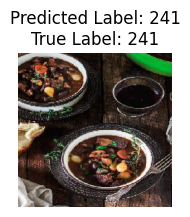

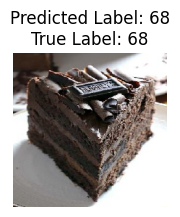

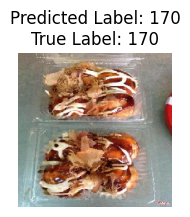

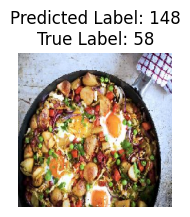

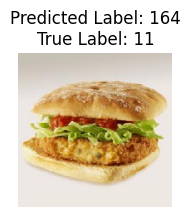

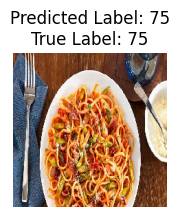

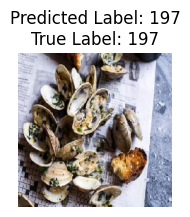

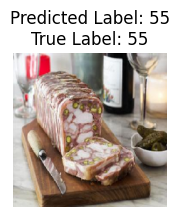

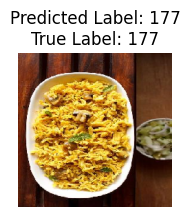

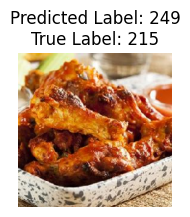

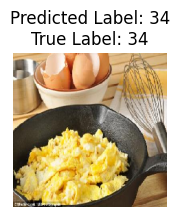

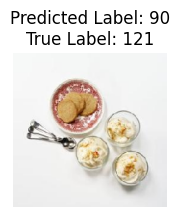

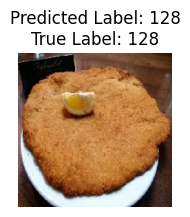

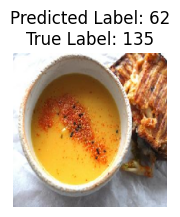

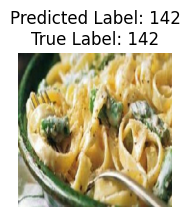

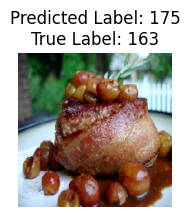

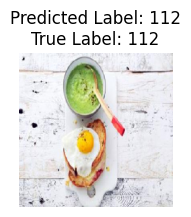

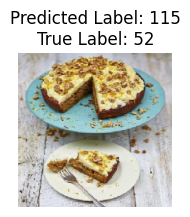

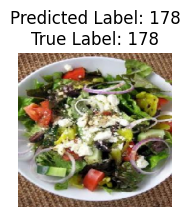

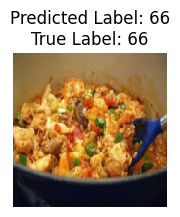

In [ ]:
class_labels = list(val_set.class_indices.keys())

test_images, test_labels = next(val_set)
predictions = loaded_model.predict(test_images)

for i in range(20):
    predicted_label_index = np.argmax(predictions[i])
    predicted_label = class_labels[predicted_label_index]
    true_label_index = np.argmax(test_labels[i])
    true_label = class_labels[true_label_index]

    plt.figure(figsize=(2,2))
    plt.imshow(test_images[i])
    plt.title(f"Predicted Label: {predicted_label}\nTrue Label: {true_label}")
    plt.axis('off')
    plt.show()


# MobileNetV2 Testing (No Longer Using)

In [ ]:
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in mobilenet.layers[:120]:
    layer.trainable = False

In [ ]:
x = mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(300, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=mobilenet.input, outputs=output)


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_set,
                    validation_data=val_set,
                    epochs=6,
                    verbose=1,
                    class_weight=class_weights_dict,
                    callbacks=[Callbacks, history_callback])

from google.colab import runtime
runtime.unassign()


Epoch 1/6
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.0545 - loss: 5.0943

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 3.27165, saving model to /content/drive/MyDrive/Mobilenet_Test/Mobilenet_best_model.keras
Epoch 1 history saved to /content/drive/MyDrive/Mobilenet_Test/mobilenet_training_history.pkl
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 1618s 895ms/step - accuracy: 0.0545 - loss: 5.0940 - val_accuracy: 0.2852 - val_loss: 3.2716 - learning_rate: 1.0000e-04
Epoch 2/6
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.2343 - loss: 3.5944
Epoch 2: val_loss improved from 3.27165 to 2.66009, saving model to /content/drive/MyDrive/Mobilenet_Test/Mobilenet_best_model.keras
Epoch 2 history saved to /content/drive/MyDrive/Mobilenet_Test/mobilenet_training_history.pkl
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 1550s 848ms/step - accuracy: 0.2343 - loss: 3.5943 - val_accuracy: 0.3775 - val_loss: 2.6601 - learning_rate: 1.0000e-04
Epoch 3/6
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.3121 - loss: 3.1421
Epoch 3: val_loss improved from 2.66009 to 2.29162, saving model to

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Mobilenet_Test/Mobilenet_best_model.keras')

In [ ]:
history_2 = loaded_model.fit(train_set,
                    validation_data=val_set,
                    epochs=6,
                    verbose=1,
                    class_weight=class_weights_dict,
                    callbacks=[Callbacks, history_callback])

from google.colab import runtime
runtime.unassign()

Epoch 1/6
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.4288 - loss: 2.4546
Epoch 1: val_loss improved from inf to 2.03594, saving model to /content/drive/MyDrive/Mobilenet_Test/Mobilenet_best_model.keras
Epoch 1 history saved to /content/drive/MyDrive/Mobilenet_Test/mobilenet_training_history_2.pkl
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 1633s 911ms/step - accuracy: 0.4288 - loss: 2.4546 - val_accuracy: 0.5043 - val_loss: 2.0359 - learning_rate: 1.0000e-04
Epoch 2/6
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.4500 - loss: 2.3559
Epoch 2: val_loss improved from 2.03594 to 1.90159, saving model to /content/drive/MyDrive/Mobilenet_Test/Mobilenet_best_model.keras
Epoch 2 history saved to /content/drive/MyDrive/Mobilenet_Test/mobilenet_training_history_2.pkl
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 1555s 869ms/step - accuracy: 0.4500 - loss: 2.3559 - val_accuracy: 0.5312 - val_loss: 1.9016 - learning_rate: 1.0000e-04
Epoch 3/6
1784/1784 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accurac

# Creating DenseNet and Testing

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def dense_block(x, growth_rate, num_layers):
    for i in range(num_layers):
        output = layers.BatchNormalization()(x)
        output = layers.ReLU()(output)
        output = layers.Conv2D(growth_rate, (3, 3), padding='same')(output)

        # Concatenate input with the new output
        x = layers.concatenate([x, output])
    return x

def transition_layer(x, reduction):
    filters = int(x.shape[-1] * reduction)  # Reduce number of filters
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.AveragePooling2D((2, 2), strides=2)(x)  # Downsample
    return x

def build_densenet(input_shape=(224, 224, 3), num_classes=251, growth_rate=32):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolution
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)


    x = dense_block(x, growth_rate, 6)
    x = transition_layer(x, 0.5)

    x = dense_block(x, growth_rate, 12)
    x = transition_layer(x, 0.5)

    x = dense_block(x, growth_rate, 24)
    x = transition_layer(x, 0.5)

    x = dense_block(x, growth_rate, 16)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model


model = build_densenet()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 112, 112, 64)   │          9,472 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_62    │ (None, 112, 112, 64)   │            256 │ conv2d_62[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_59 (ReLU)           │ (None, 112, 112, 64)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ re_lu_59[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_63    │ (None, 56, 56, 64)     │            256 │ max_pooling2d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_60 (ReLU)           │ (None, 56, 56, 64)     │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 56, 56, 32)     │         18,464 │ re_lu_60[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_58            │ (None, 56, 56, 96)     │              0 │ max_pooling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_63[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_64    │ (None, 56, 56, 96)     │            384 │ concatenate_58[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_61 (ReLU)           │ (None, 56, 56, 96)     │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 56, 56, 32)     │         27,680 │ re_lu_61[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_59            │ (None, 56, 56, 128)    │              0 │ concatenate_58[0][0],  │
│ (Concatenate)             │                        │                │ conv2d_64[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_65    │ (None, 56, 56, 128)    │            512 │ concatenate_59[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_62 (ReLU)           │ (None, 56, 56, 128)    │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)   

 Total params: 10,168,891 (38.79 MB)

 Trainable params: 10,102,139 (38.54 MB)

 Non-trainable params: 66,752 (260.75 KB)

In [ ]:
'''
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_set,
                      validation_data=val_set,
                      epochs=6,
                      verbose=1,
                      class_weight=class_weights_dict,
                      callbacks=[Callbacks, history_callback])

'''

loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/CNN_Model_Tests/Created_Dense_Best.keras')

history = loaded_model.fit(train_set,
                      validation_data=val_set,
                      epochs=6,
                      verbose=1,
                      class_weight=class_weights_dict,
                      callbacks=[Callbacks, history_callback])

from google.colab import runtime
runtime.unassign()

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3568/3568 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.4491 - loss: 2.3340
Epoch 1: val_loss improved from inf to 2.23550, saving model to /content/drive/MyDrive/CNN_Model_Tests/Created_Dense_Best.keras
Epoch 1 history saved to /content/drive/MyDrive/CNN_Model_Tests/created_Dense_train_history_4.pkl
3568/3568 ━━━━━━━━━━━━━━━━━━━━ 2076s 548ms/step - accuracy: 0.4491 - loss: 2.3340 - val_accuracy: 0.4695 - val_loss: 2.2355 - learning_rate: 2.0000e-04
Epoch 2/6
3568/3568 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.4618 - loss: 2.2768
Epoch 2: val_loss did not improve from 2.23550
Epoch 2 history saved to /content/drive/MyDrive/CNN_Model_Tests/created_Dense_train_history_4.pkl
3568/3568 ━━━━━━━━━━━━━━━━━━━━ 1857s 516ms/step - accuracy: 0.4618 - loss: 2.2768 - val_accuracy: 0.4684 - val_loss: 2.2542 - learning_rate: 2.0000e-04
Epoch 3/6
3568/3568 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.4678 - loss: 2.2165
Epoch 3: val_loss did not improve from 2.23550
Epoch 3 history saved

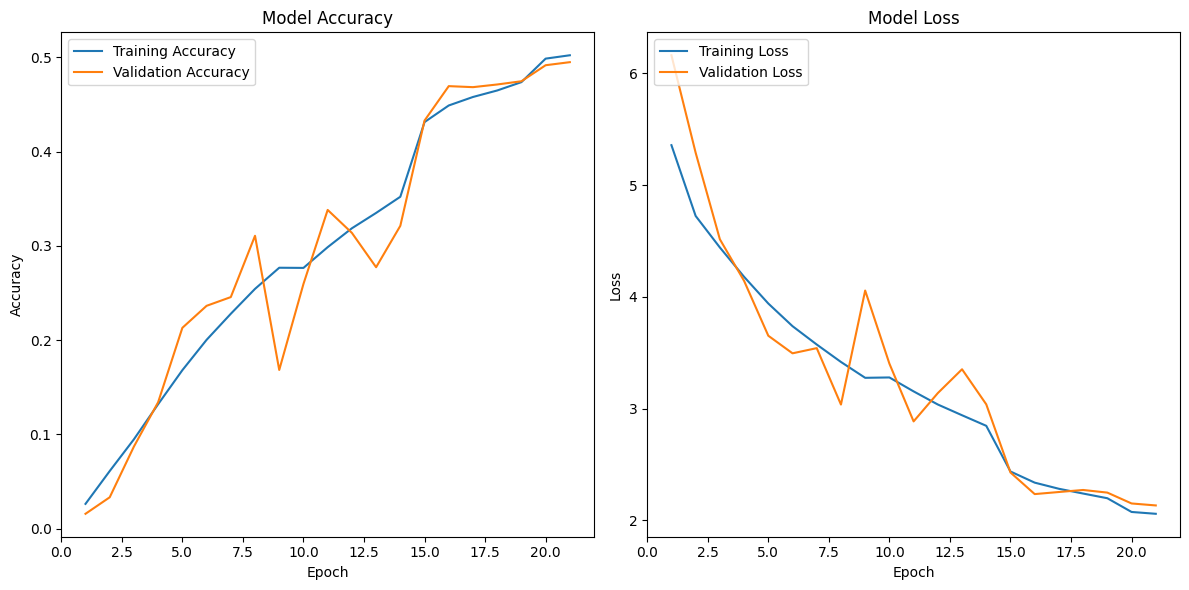

In [ ]:
# Load the history from all sessions
with open('/content/drive/MyDrive/CNN_Model_Tests/created_Dense_train_history.pkl', 'rb') as file:
    history1 = pickle.load(file)

with open('/content/drive/MyDrive/CNN_Model_Tests/created_Dense_train_history_2.pkl', 'rb') as file:
    history2 = pickle.load(file)

with open('/content/drive/MyDrive/CNN_Model_Tests/created_Dense_train_history_3.pkl', 'rb') as file:
    history3 = pickle.load(file)

with open('/content/drive/MyDrive/CNN_Model_Tests/created_Dense_train_history_4.pkl', 'rb') as file:
    history4 = pickle.load(file)

combined_history = {}
for key in history1.keys():
    combined_history[key] = history1[key] + history2[key] + history3[key] + history4[key]

epochs = np.arange(1, len(combined_history['loss']) + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, combined_history['accuracy'], label='Training Accuracy')
plt.plot(epochs, combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, combined_history['loss'], label='Training Loss')
plt.plot(epochs, combined_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
